In [1]:
import pandas as pd
import numpy as np
import sys
from os import getcwd
from os.path import join
sys.path.insert(0, join(getcwd(), '..'))
import sentiment


DATASET_DIR = '../goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

D:\sentiment-analysis\pre-encoded\..\sentiment.py:182: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (train_df['labels'].str.contains(r'(^|,)' + label + r'(,|$)', regex=True))
D:\sentiment-analysis\pre-encoded\..\sentiment.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


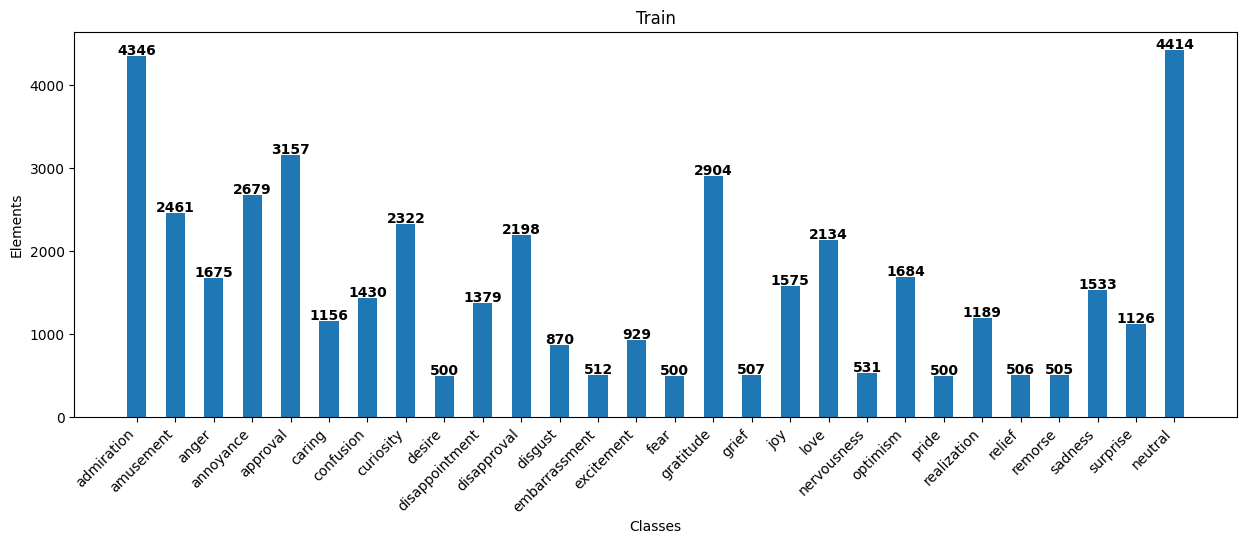

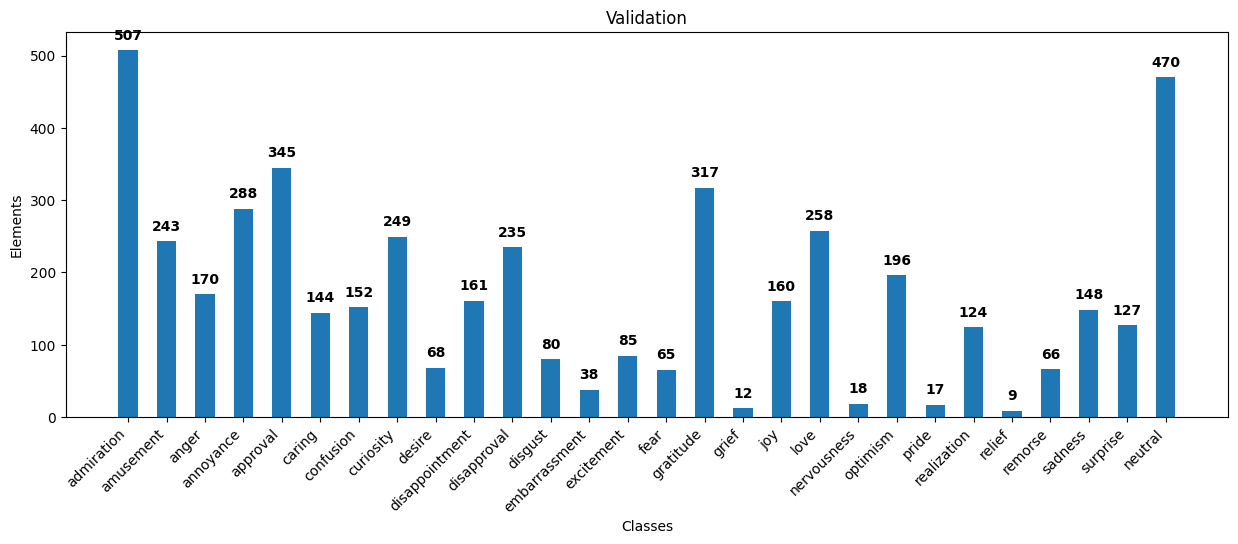

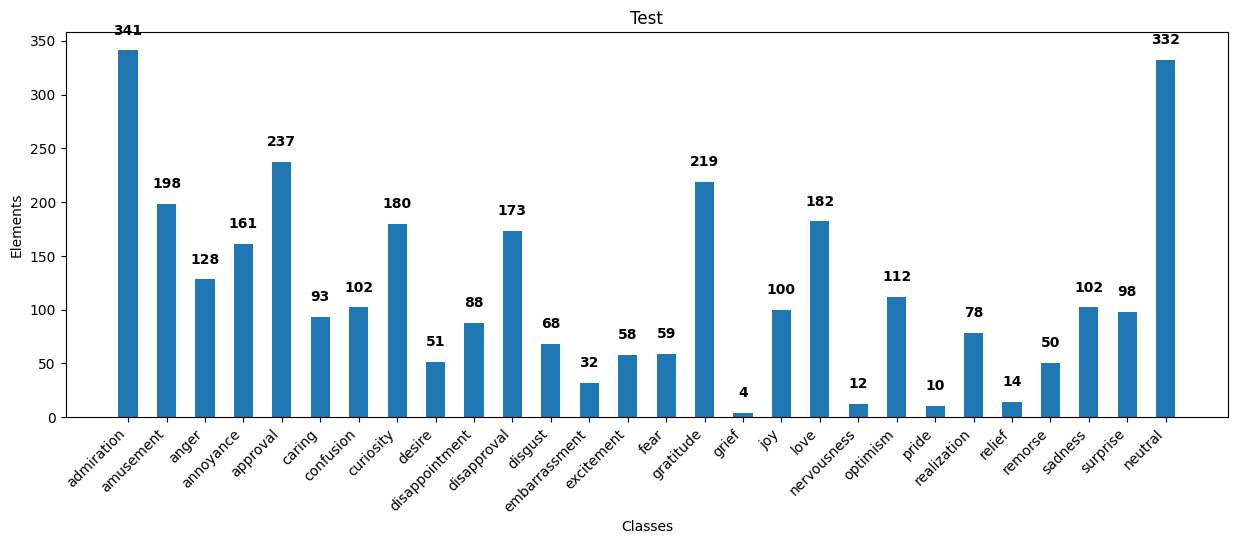

CPU times: total: 7.31 s
Wall time: 9.58 s


In [3]:
%%time
train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.9,
                                                      clean=True,
                                                      cut_neutral=True,
                                                      test_only_singles=True,
                                                      oversample_low=True,
                                                      low_threshold=500)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)

In [4]:
train_df.shape[0], val_df.shape[0], test_df.shape[0]

(35878, 3836, 3282)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)


# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Create keyword arguments to pass to the 'tf-idf' vectorizer.
kwargs = {
    'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': TOKEN_MODE,  # Split text into word tokens.
    'min_df': MIN_DOCUMENT_FREQUENCY,
}
vectorizer = TfidfVectorizer(**kwargs)

# Learn vocabulary from training texts and vectorize training texts.
vectorizer.fit(train_df['text'])

C:\Users\mihai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


TfidfVectorizer(decode_error='replace', dtype='int32', min_df=2,
                ngram_range=(1, 2), strip_accents='unicode')

In [6]:
classes_qty = len(classes)
def encode_onehot(labels):
    encoded = np.zeros(classes_qty)
    for label in labels.split(','):
        encoded[int(label)] = 1
    return encoded

In [7]:
train_df.shape

(35878, 2)

In [8]:
X_vectorized = vectorizer.transform(train_df['text'])

In [9]:
X_vectorized.shape

(35878, 50047)

In [10]:
y = train_df['labels'].apply(encode_onehot).values
y = np.vstack(y)

In [11]:
from sklearn.feature_selection import chi2, SelectKBest

features_scores = [] 
for label, _ in enumerate(classes):
    selector = SelectKBest(chi2, k='all')
    selector.fit(X_vectorized, y[:, label])
    features_scores.append(list(selector.scores_))

In [12]:
total_scores = np.array(features_scores).sum(axis=0)
total_scores.shape

(50047,)

In [13]:
TOP_K = 20_000

selected_features = total_scores.argsort()[-1*TOP_K:]

In [14]:
X_vectorized[:, selected_features]

<35878x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 515519 stored elements in Compressed Sparse Row format>

In [15]:
def make_encoded(vectorizer, features, df):
    X_vectors = vectorizer.transform(df['text'])
    X_vectors_sel = X_vectors[:, features]
    y_encoded = df['labels'].apply(encode_onehot).values
    y_encoded = np.vstack(y_encoded)
    return (X_vectors_sel.toarray().astype('float32'), y_encoded.astype('float32'))

In [16]:
for fname, df in {'train': train_df, 'val': val_df, 'test': test_df}.items():
    X, y = make_encoded(vectorizer, selected_features, df)
    with open(fname + '_X.npy', 'wb') as X_file:
        np.save(X_file, X)
    with open(fname + '_y.npy', 'wb') as y_file:
        np.save(y_file, y)

In [17]:
import pickle

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file, pickle.HIGHEST_PROTOCOL)
    
with open('features.pkl', 'wb') as file:
    pickle.dump(selected_features, file, pickle.HIGHEST_PROTOCOL)

In [18]:
selected_tokens = []
for token, index in vectorizer.vocabulary_.items():
    if index in selected_features:
        selected_tokens.append(token)

In [19]:
from random import choices

choices(selected_tokens, k=100)

['flinched',
 'get an',
 'gags',
 'understand what',
 'seen stick',
 'your day',
 'understood',
 'it helps',
 'weird as',
 'shit did',
 'statistics saw',
 'instructed',
 'both lol',
 'sent it',
 'yeah feel',
 'get two',
 'with joy',
 'too those',
 'wink',
 'channel and',
 'also out',
 'great person',
 'would the',
 'be worried',
 'asia',
 'the state',
 'reject your',
 'one everywhere',
 'backpedal',
 'what right',
 'what joke',
 'space like',
 'me really',
 'your service',
 'so just',
 'acronym',
 'hair gel',
 'everywhere is',
 'poster so',
 'date sorry',
 'obvs',
 'but do',
 'to skip',
 'season was',
 'exausted drink',
 'talking prior',
 'do though',
 'hungry are',
 'hatred',
 'love he',
 'more enjoyable',
 'so sweet',
 'just spouting',
 'has crush',
 'ideas and',
 'going that',
 'seriously definitely',
 'got any',
 'people hate',
 'but seeing',
 'same bro',
 'hey maybe',
 'hold job',
 'career kd',
 'soap',
 'source on',
 'be exhausting',
 'resenting',
 'thing faker',
 'misunderstandi